In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time

import plotly.io as pio
pio.renderers.default = 'notebook'

In [2]:
from dope.fetcher.coingecko import CoinGecko
# btc = CoinGecko().get_price("bitcoin", "2023-08-09", "2024-04-01")

In [3]:
eth = CoinGecko().get_last_year_price("ethereum")
steth = CoinGecko().get_last_year_price("staked-ether")

In [4]:
from dope.fetcher.llama import Llama
from dope.market_impact.linear import LinearMktImpactModel

In [5]:
universe_dict = {
  "WETH": """
    https://defillama.com/yields/pool/e880e828-ca59-4ec6-8d4f-27182a4dc23d
    https://defillama.com/yields/pool/c11cb1b9-3cd5-4252-93da-51b130fc4f45
    """,
 "WSTETH":"""
   # aave-v3:
   https://defillama.com/yields/pool/e6435aae-cbe9-4d26-ab2c-a4d533db9972
   # https://defillama.com/yields/pool/3b45941c-16cb-48c5-a490-16c6c4f1d86a
   """,
  "STETH":"""
  https://defillama.com/yields/pool/747c1d2a-c668-4682-b9f9-296708a3dd90
  """
}
def url_raw_to_pool_id(url_raw):
  return [url.split("/")[-1] for url in  url_raw.split("\n")[1:-1] if "#" not in url]

pool_ids = {t:url_raw_to_pool_id(pool_ids) for t, pool_ids in universe_dict.items()}

In [6]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [7]:
data, borrow_lend_data = maestro.load_defilama_with_token_pool_id(pool_ids)

WETH
Ethereum:aave-v3:WETH e880e828-ca59-4ec6-8d4f-27182a4dc23d 463 463
Ethereum:gearbox:WETH c11cb1b9-3cd5-4252-93da-51b130fc4f45 218 218
WSTETH
Ethereum:aave-v3:WSTETH e6435aae-cbe9-4d26-ab2c-a4d533db9972 463 463
STETH
Ethereum:lido:STETH 747c1d2a-c668-4682-b9f9-296708a3dd90 436 436


In [8]:
#borrow_lend_data = {t:{} for t in borrow_lend_data.keys()}
for token in borrow_lend_data.keys():
  for mkt in borrow_lend_data[token].keys():
    borrow_lend_data[token][mkt] = borrow_lend_data[token][mkt].resample("1D").last().interpolate().fillna(np.nan)

from dope.backengine.maestro import BacktestData

borrow_lend_data = BacktestData(borrow_lend_data)

In [9]:
maestro.set_data(borrow_lend_data)

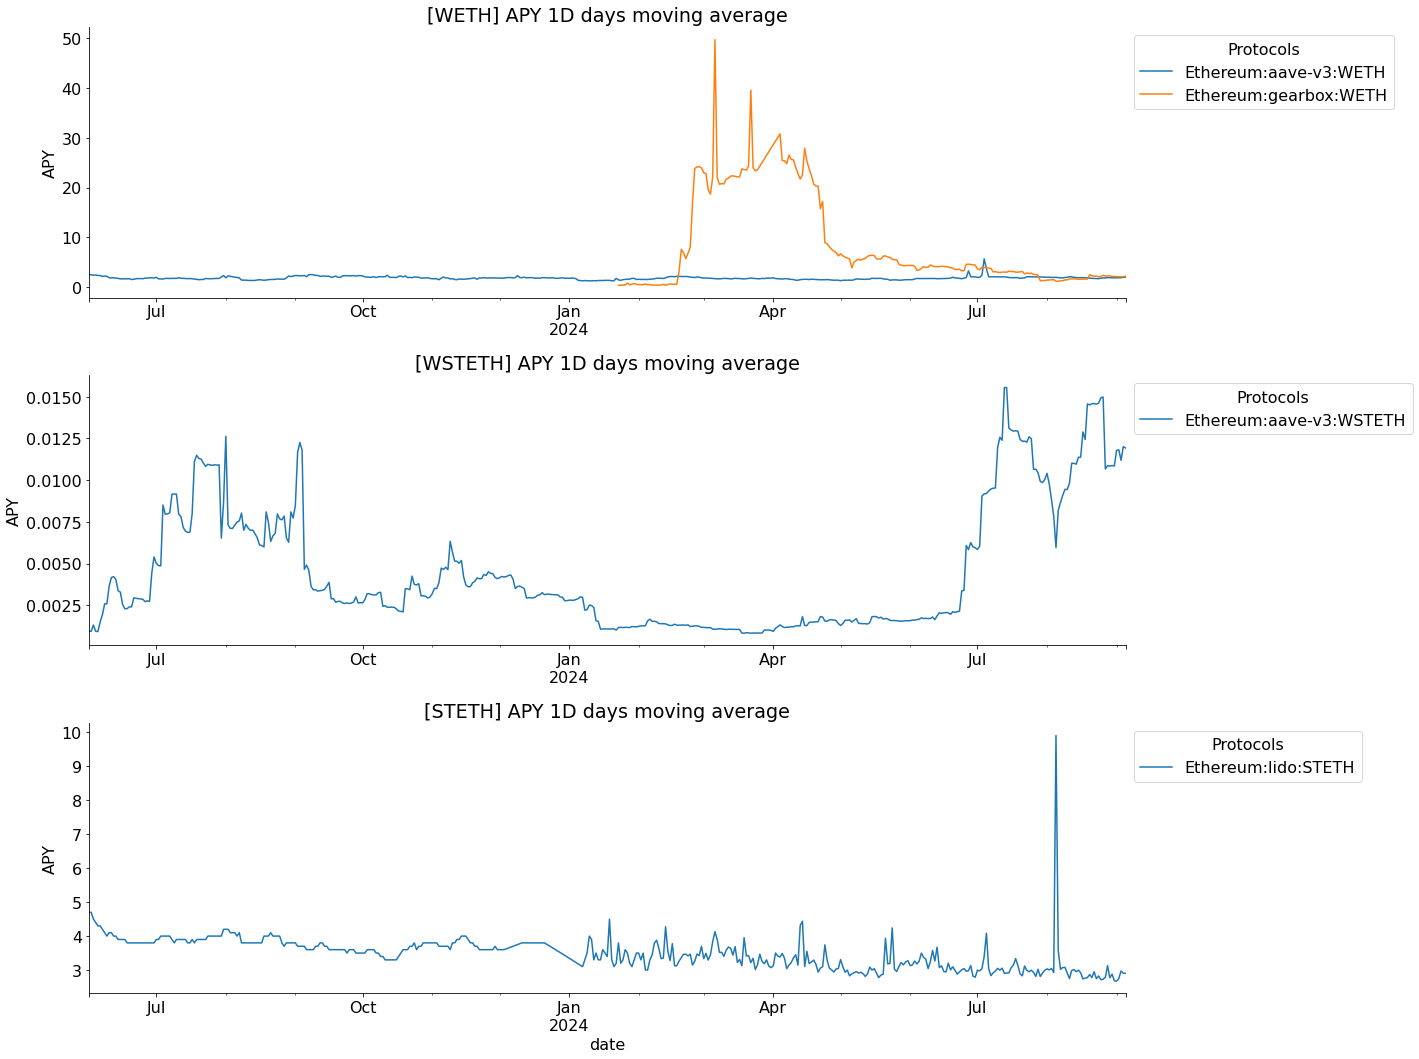

In [10]:
maestro.plot_rates_ts()

In [480]:
# from dope.backengine.estimators.estimator import Estimator
# from dope.backengine.estimators.clippedestimator import ClippedEstimator
# from dope.backengine.triggers.confidencebandtrigger import ConfidenceBandTrigger

# from dope.backengine.maestro import BackEngineMaestro
# _data = pd.concat(borrow_lend_data['stETH'], names=["datetime"]).unstack(level=0)
# lag = 7 # 1 week window for mu and sigma estimation
# triggerObj = ConfidenceBandTrigger(_data, lag, Estimator(), rt_col='apyBaseBorrow')
# triggers2 = triggerObj.dates()

In [1169]:
def loop_n(n, X, tvl):
  return X * (1-tvl**(n+1)) / (1- tvl)

In [11]:
borrow_token = "WETH"
borrow_mkt = "Ethereum:gearbox:WETH"
supply_token = "STETH"
supply_mkt = "Ethereum:lido:STETH"

run_data = borrow_lend_data


leverage = 2 4.11%
leverage = 3 5.40%
leverage = 5 7.92%
leverage = 7 10.39%
leverage = 8 11.60%
leverage = 10 13.98%


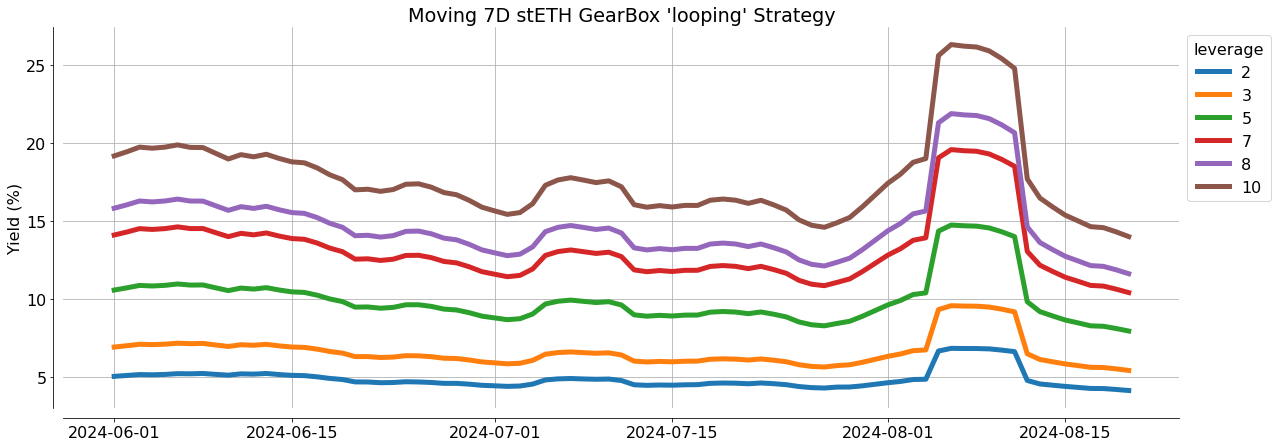

In [487]:
leverage = 5
plt.figure(figsize=(20,7))
for leverage in [2, 3, 5, 7, 8, 10]:
  supply_cap = 1
  debt_cap = leverage - supply_cap
  supply_cap = 1 * leverage



  run_data = borrow_lend_data

  daily_apy = (
    run_data[supply_token][supply_mkt].apyBase * supply_cap
    - (run_data[borrow_token][borrow_mkt].apyBaseBorrow + 0.007) * debt_cap
  )
  #plt.plot(daily_apy)
  #plt.xlim(pd.Timestamp("2024-06-01"))

  d = 7
  tmp = (
    (np.exp(np.log(((1+daily_apy /100)**(1/365))).rolling(window=f"{d}D").sum())-1)
    *365/d *100)
  tmp = tmp[tmp.index>="2024-06-01"]
  plt.plot(tmp, label=leverage, linewidth=5)
  plt.title(f"Moving {d}D stETH GearBox 'looping' Strategy")
  plt.ylabel("Yield (%)")
  print(f"{leverage = }", f"{tmp.iloc[-1]:,.2f}%")

ax = plt.gca()
ax.set_xlabel("")
#ax.set_ylabel("Returns (in %)")
_ = plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="leverage")
# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Optionally, you can also move the left and bottom spines
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.grid()

# BackTester

In [12]:
from dope.backengine.loopengine import LoopBacktester, TokenAccount
from dope.backengine.agents.gearboxlooper import GearBoxLooper

from dope.backengine.maestro import PriceData

In [14]:
#run_data = borrow_lend_data

In [15]:
from dope.market_impact.neighborhood import NeighborhoodMktImpactModel
mkt_impact = {mkt:NeighborhoodMktImpactModel() for mkt in run_data.get_markets()}
mkt_impact["cash"] = NeighborhoodMktImpactModel()

In [16]:
run_data = borrow_lend_data.convert_tvl_from_usd(eth)

In [17]:
summaries = {}
price_data = PriceData({"ETH":eth/eth, "STETH":steth/eth})
protocol_token_name_dict = {
  # Pool Token : Price Token
  "WETH": "ETH", 
  "WSTETH":"STETH", 
  "STETH":"STETH"
}

price_data.set_mkt_to_token(run_data, protocol_token_name_dict)

In [25]:



debt_pool = "Ethereum:gearbox:WETH"
deposit_pool = "Ethereum:lido:STETH"

capital = 1
strategy = GearBoxLooper(leverage=10, capital=capital, debt_pool=debt_pool, deposit_pool=deposit_pool)

In [26]:
bt = LoopBacktester(
  strategy=strategy,
  data=run_data,
  price_data=price_data, 
  liquidation_threshold=0.945, 
  mkt_impact=mkt_impact
)

In [30]:
summaries = {}
summaries[f"capital:{capital}"] = bt()

Running Backtest for 463 | token:NO-TOKEN
{'Ethereum:lido:STETH': 9.43479651031169, 'Ethereum:gearbox:WETH': -8.43479651031169}


In [32]:
summaries = {}

collateral = 1
for collateral in [1, 10, 100, 1_000]:
  strategy = GearBoxLooper(leverage=10, capital=collateral, debt_pool=debt_pool, deposit_pool=deposit_pool)
  bt = LoopBacktester(
    strategy=strategy,
    data=run_data,
    price_data=price_data, 
    liquidation_threshold=0.945,
    mkt_impact=mkt_impact
  )

  summaries[f"capital:{collateral}"] = bt(start_timestamp="2024-02-01")

Running Backtest for 463 | token:NO-TOKEN
{'Ethereum:lido:STETH': 10.045843744296409, 'Ethereum:gearbox:WETH': -9.045843744296409}
Running Backtest for 463 | token:NO-TOKEN
{'Ethereum:lido:STETH': 10.045843744296409, 'Ethereum:gearbox:WETH': -9.045843744296409}
Running Backtest for 463 | token:NO-TOKEN
{'Ethereum:lido:STETH': 10.045843744296404, 'Ethereum:gearbox:WETH': -9.045843744296404}
Running Backtest for 463 | token:NO-TOKEN
{'Ethereum:lido:STETH': 10.04584374429641, 'Ethereum:gearbox:WETH': -9.04584374429641}


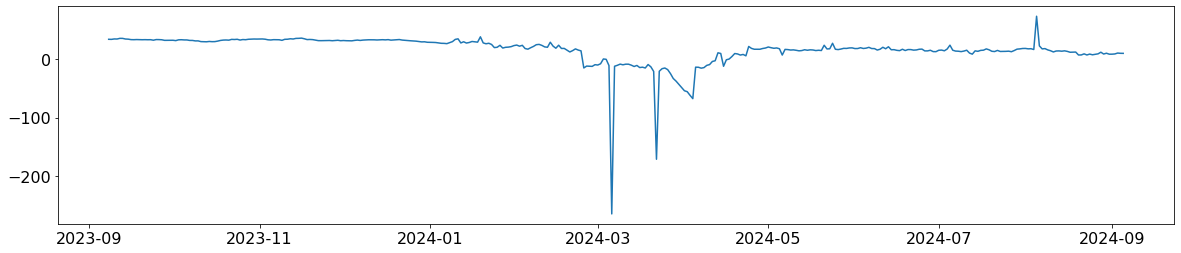

In [31]:
plt.plot(summaries["capital:1"].rate, label="1 ETH")
plt.plot(summaries["capital:1"].rate, label="1 ETH")

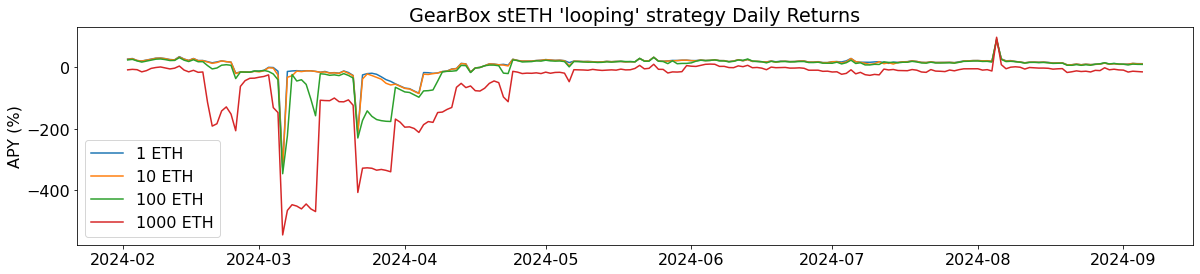

In [34]:
plt.plot(summaries["capital:1"].rate, label="1 ETH")
plt.plot(summaries["capital:10"].rate, label="10 ETH")
plt.plot(summaries["capital:100"].rate, label="100 ETH")
plt.plot(summaries["capital:1000"].rate, label="1000 ETH")
plt.title("GearBox stETH 'looping' strategy Daily Returns")
plt.ylabel("APY (%)")
plt.legend()

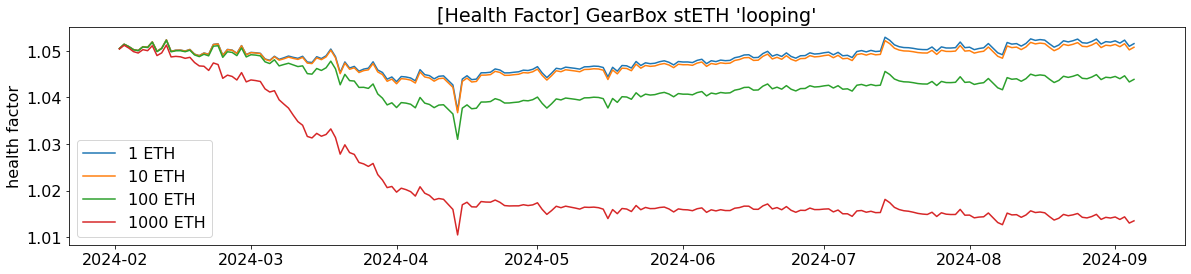

In [36]:
plt.plot(summaries["capital:1"].health_factor, label="1 ETH")
plt.plot(summaries["capital:10"].health_factor, label="10 ETH")
plt.plot(summaries["capital:100"].health_factor, label="100 ETH")
plt.plot(summaries["capital:1000"].health_factor, label="1000 ETH")
plt.title("[Health Factor] GearBox stETH 'looping'")
plt.ylabel("health factor")
plt.legend()

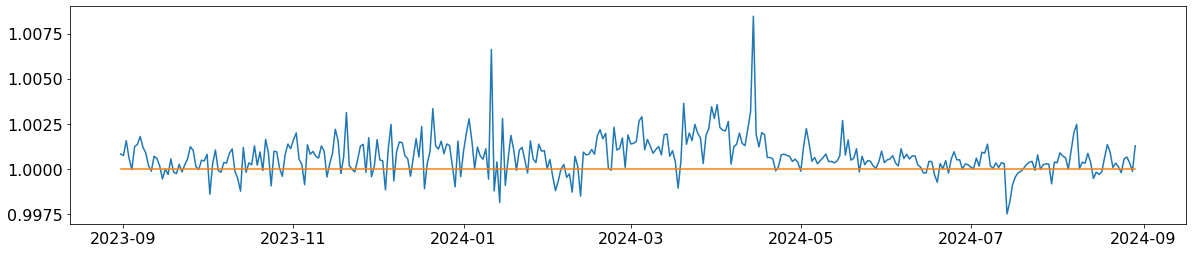

In [1161]:
plt.plot(eth/steth)
plt.plot(eth/eth)